In [60]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
data =  pd.read_csv('/content/Data_with_new_feature.csv')

In [64]:
data

,price,avg_rating,cnt_reviews,pages_cnt,tirage,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight_per_page,is_2024_2025,age_6_minus,age_16_plus
0,5.743003,4.1,925,512,10.308953,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0
1,5.743003,4.1,1341,320,10.308953,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0
2,5.648974,4.5,363,192,10.126631,1.0,0.0,0.0,0.0,0.0,0.687500,1.0,0.0,1.0
3,5.826000,4.3,872,288,9.392662,1.0,0.0,0.0,0.0,0.0,0.725694,1.0,0.0,1.0
4,5.648974,4.2,3004,320,10.308953,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,7.123673,5.0,3,624,7.313220,0.0,0.0,0.0,1.0,1.0,1.538462,0.0,0.0,1.0
3186,7.699389,3.7,53,448,7.313220,0.0,0.0,0.0,1.0,1.0,1.696429,0.0,0.0,1.0
3187,7.005789,4.3,42,784,8.006368,0.0,0.0,1.0,0.0,1.0,1.096939,0.0,0.0,1.0
3188,6.918695,3.8,29,704,7.600902,0.0,0.0,0.0,1.0,1.0,0.906250,0.0,0.0,1.0


In [62]:
data['price'] = np.log(data['price'])
data['tirage'] = np.log(data['tirage'])

In [63]:
data = data.rename(columns={
    'weight/page_cnt': 'weight_per_page',
    '2024_or_2025': 'is_2024_2025',
    '6-': 'age_6_minus',
    '16+': 'age_16_plus'
})
data.drop(columns='const', axis=1, inplace=True)

In [ ]:
str_predictors = 'price ~ avg_rating + cnt_reviews + pages_cnt + tirage + ' \
          'publisher_АСТ + publisher_Азбука + publisher_Иностранка + publisher_Эксмо + ' \
          'cover_type_Твёрдый_переплёт + weight_per_page + is_2024_2025 + age_6_minus + age_16_plus'

predictors = ['avg_rating', 'cnt_reviews', 'pages_cnt', 'tirage',
       'publisher_АСТ', 'publisher_Азбука', 'publisher_Иностранка',
       'publisher_Эксмо', 'cover_type_Твёрдый_переплёт', 'weight_per_page',
       'is_2024_2025', 'age_6_minus', 'age_16_plus']

In [ ]:
# Обычная линейная регрессия (OLS)
ols_model = smf.ols(str_predictors, data=data).fit()
ols_conf_int = ols_model.conf_int()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     660.0
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        17:30:38   Log-Likelihood:                -243.32
No. Observations:                3190   AIC:                             514.6
Df Residuals:                    3176   BIC:                             599.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:
from tqdm import tqdm
from scipy import stats

# Устанавливаем seed для воспроизводимости
np.random.seed(1001)

# Параметры анализа
quantiles_mq = [0.1, 0.5, 0.75, 0.9]
models_mq = []  # здесь будем хранить финальные модели с правильными SE
n_boot = 50

# Бутстрэп-процедура
print("Запуск бутстрэп-процедуры...")
bootstrap_coefs = {q: [] for q in quantiles_mq}
for _ in tqdm(range(n_boot), desc="Прогресс"):
    bootstrap_sample = data.sample(n=len(data), replace=True)
    for q in quantiles_mq:
        model = smf.quantreg(str_predictors, data=bootstrap_sample).fit(q=q)
        bootstrap_coefs[q].append(model.params)

for q in quantiles_mq:
    # Основная модель
    main_model = smf.quantreg(str_predictors, data=data).fit(q=q)

    # Рассчитываем бутстрап-стандартные ошибки
    coefs = pd.DataFrame(bootstrap_coefs[q])
    bse = coefs.std()

    # Создаем новую модель с бутстрап-SE
    main_model.bse = bse  # перезаписываем стандартные ошибки
    models_mq.append(main_model)

Запуск бутстрэп-процедуры...


Прогресс:   6%|▌         | 3/50 [00:02<00:33,  1.42it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
Прогресс:  36%|███▌      | 18/50 [00:22<00:41,  1.30s/it]/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
Прогресс:  96%|█████████▌| 48/50 [00:50<00:01,  1.36it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
Прогресс: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


In [ ]:
# Функция для создания красивой таблицы
def create_results_table(q):
    main_model = smf.quantreg(str_predictors, data=data).fit(q=q)
    coefs_df = pd.DataFrame(bootstrap_coefs[q])
    bse = coefs_df.std()

    results = pd.DataFrame({
        'factor': predictors,
        'coeff': [main_model.params[p] for p in predictors],
        'std err (boot)': [bse[p] for p in predictors],
        '95% CI low': [main_model.params[p] - 1.96*bse[p] for p in predictors],
        '95% CI high': [main_model.params[p] + 1.96*bse[p] for p in predictors],
        't-stat': [main_model.params[p]/bse[p] for p in predictors],
        'p-value': [2*(1-stats.norm.cdf(abs(main_model.params[p]/bse[p]))) for p in predictors]
    })

    # Форматирование чисел
    for col in results.columns[1:]:
        results[col] = results[col].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

    return results

# Вывод результатов для каждого квантиля
for q in quantiles_mq:
    print(f"\n{'='*80}")
    print(f"=== Результаты квантильной регрессии для квантиля {q} (бутстрэп, n={n_boot}) ===")
    print(f"{'='*80}\n")

    results_table = create_results_table(q)
    display(results_table)


=== Результаты квантильной регрессии для квантиля 0.1 (бутстрэп, n=50) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,avg_rating,0.0305,0.0131,0.0048,0.0561,2.3289,0.0199
1,cnt_reviews,0.0002,0.0001,0.0001,0.0004,3.4647,0.0005
2,pages_cnt,0.0006,0.0001,0.0005,0.0007,10.9259,0.0000
3,tirage,-0.1198,0.0104,-0.1402,-0.0995,-11.5542,0.0000
4,publisher_АСТ,-0.1191,0.0865,-0.2886,0.0505,-1.3766,0.1686
5,publisher_Азбука,-0.1262,0.0911,-0.3047,0.0524,-1.3851,0.1660
6,publisher_Иностранка,0.6337,0.0909,0.4556,0.8118,6.9746,0.0000
7,publisher_Эксмо,-0.1365,0.0895,-0.3120,0.0389,-1.5252,0.1272
8,cover_type_Твёрдый_переплёт,0.0309,0.0353,-0.0383,0.1000,0.8752,0.3815
9,weight_per_page,0.3965,0.1396,0.1229,0.6701,2.8408,0.0045



=== Результаты квантильной регрессии для квантиля 0.5 (бутстрэп, n=50) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,avg_rating,0.0411,0.0114,0.0188,0.0634,3.6140,0.0003
1,cnt_reviews,0.0004,0.0001,0.0003,0.0005,6.7506,0.0000
2,pages_cnt,0.0010,0.0000,0.0009,0.0010,35.3243,0.0000
3,tirage,-0.1651,0.0195,-0.2033,-0.1270,-8.4855,0.0000
4,publisher_АСТ,-0.0362,0.0402,-0.1149,0.0425,-0.9021,0.3670
5,publisher_Азбука,0.0060,0.0371,-0.0667,0.0788,0.1625,0.8709
6,publisher_Иностранка,0.1064,0.0399,0.0281,0.1847,2.6640,0.0077
7,publisher_Эксмо,-0.0398,0.0382,-0.1146,0.0351,-1.0417,0.2976
8,cover_type_Твёрдый_переплёт,0.0726,0.0314,0.0111,0.1342,2.3136,0.0207
9,weight_per_page,1.1844,0.0625,1.0620,1.3068,18.9633,0.0000



=== Результаты квантильной регрессии для квантиля 0.75 (бутстрэп, n=50) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,avg_rating,0.0159,0.0127,-0.0089,0.0408,1.2583,0.2083
1,cnt_reviews,0.0003,0.0001,0.0002,0.0004,4.7353,0.0000
2,pages_cnt,0.0010,0.0000,0.0009,0.0010,42.8915,0.0000
3,tirage,-0.1252,0.0141,-0.1528,-0.0975,-8.8753,0.0000
4,publisher_АСТ,-0.0132,0.0322,-0.0764,0.0499,-0.4115,0.6807
5,publisher_Азбука,-0.0068,0.0343,-0.0740,0.0605,-0.1978,0.8432
6,publisher_Иностранка,0.0225,0.0360,-0.0480,0.0930,0.6253,0.5317
7,publisher_Эксмо,0.0238,0.0331,-0.0411,0.0886,0.7176,0.4730
8,cover_type_Твёрдый_переплёт,0.1964,0.0237,0.1500,0.2428,8.2959,0.0000
9,weight_per_page,1.1370,0.0536,1.0320,1.2420,21.2194,0.0000



=== Результаты квантильной регрессии для квантиля 0.9 (бутстрэп, n=50) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,avg_rating,0.0139,0.0161,-0.0176,0.0454,0.8678,0.3855
1,cnt_reviews,0.0003,0.0001,0.0002,0.0004,5.7137,0.0000
2,pages_cnt,0.0009,0.0000,0.0009,0.0010,32.4304,0.0000
3,tirage,-0.0938,0.0133,-0.1198,-0.0678,-7.0716,0.0000
4,publisher_АСТ,-0.0866,0.0403,-0.1657,-0.0075,-2.1465,0.0318
5,publisher_Азбука,-0.1054,0.0417,-0.1871,-0.0238,-2.5301,0.0114
6,publisher_Иностранка,-0.0925,0.0425,-0.1758,-0.0093,-2.1779,0.0294
7,publisher_Эксмо,-0.0165,0.0421,-0.0990,0.0659,-0.3932,0.6942
8,cover_type_Твёрдый_переплёт,0.2224,0.0238,0.1757,0.2692,9.3287,0.0000
9,weight_per_page,1.1683,0.0590,1.0527,1.2838,19.8150,0.0000


In [ ]:
# Тест на равенство коэффициентов в моделях разных квантилей
from scipy import stats

# Список столбцов
columns = [
    'Коэффициент для q=0.1',
    'Коэффициент для q=0.5',
    'Разность коэффициентов',
    'Wald statistic',
    'P-value'
]
df = pd.DataFrame(index=predictors, columns=columns)


for predictor in predictors:
    coef_01 = models_mq[0].params[predictor]  # для q=0.1
    coef_09 = models_mq[1].params[predictor]  # для q=0.9

    se_01 = pd.DataFrame(bootstrap_coefs[0.1]).std()[predictor]  # стандартная ошибка для q=0.1
    se_09 = pd.DataFrame(bootstrap_coefs[0.5]).std()[predictor]  # стандартная ошибка для q=0.9

    # Вычисляем разность коэффициентов и её стандартную ошибку
    diff = coef_01 - coef_09
    se_diff = np.sqrt(se_01**2 + se_09**2)  # стандартная ошибка разности

    # Вычисляем статистику Вальда
    wald_stat = diff / se_diff
    p_value = 2 * (1 - stats.norm.cdf(abs(wald_stat)))  # двусторонний тест

    df.loc[predictor, 'Коэффициент для q=0.1'] = coef_01
    df.loc[predictor, 'Коэффициент для q=0.5'] = coef_09
    df.loc[predictor, 'Разность коэффициентов'] = diff
    df.loc[predictor, 'Wald statistic'] = wald_stat
    df.loc[predictor, 'P-value'] = p_value

# Интерпретация результата
# alpha = 0.05
# if p_value < alpha:
#     print(f"\nЗаключение: Отвергаем нулевую гипотезу (p={p_value:.4f} < {alpha}). Коэффициенты статистически значимо различаются.")
# else:
#     print(f"\nЗаключение: Не отвергаем нулевую гипотезу (p={p_value:.4f} >= {alpha}). Нет доказательств различия коэффициентов.")

In [ ]:
df

,Коэффициент для q=0.1,Коэффициент для q=0.5,Разность коэффициентов,Wald statistic,P-value
avg_rating,0.030489,0.041125,-0.010636,-0.613154,0.539774
cnt_reviews,0.000241,0.000381,-0.00014,-1.569084,0.116628
pages_cnt,0.000574,0.000954,-0.00038,-6.433287,0.0
tirage,-0.119841,-0.165137,0.045296,2.053975,0.039978
publisher_АСТ,-0.119059,-0.036222,-0.082837,-0.868712,0.385005
publisher_Азбука,-0.126183,0.006034,-0.132217,-1.343973,0.178957
publisher_Иностранка,0.633677,0.106413,0.527264,5.312565,0.0
publisher_Эксмо,-0.136537,-0.039772,-0.096765,-0.994269,0.320092
cover_type_Твёрдый_переплёт,0.030871,0.072644,-0.041773,-0.884571,0.376388
weight_per_page,0.396511,1.184384,-0.787874,-5.152465,0.0


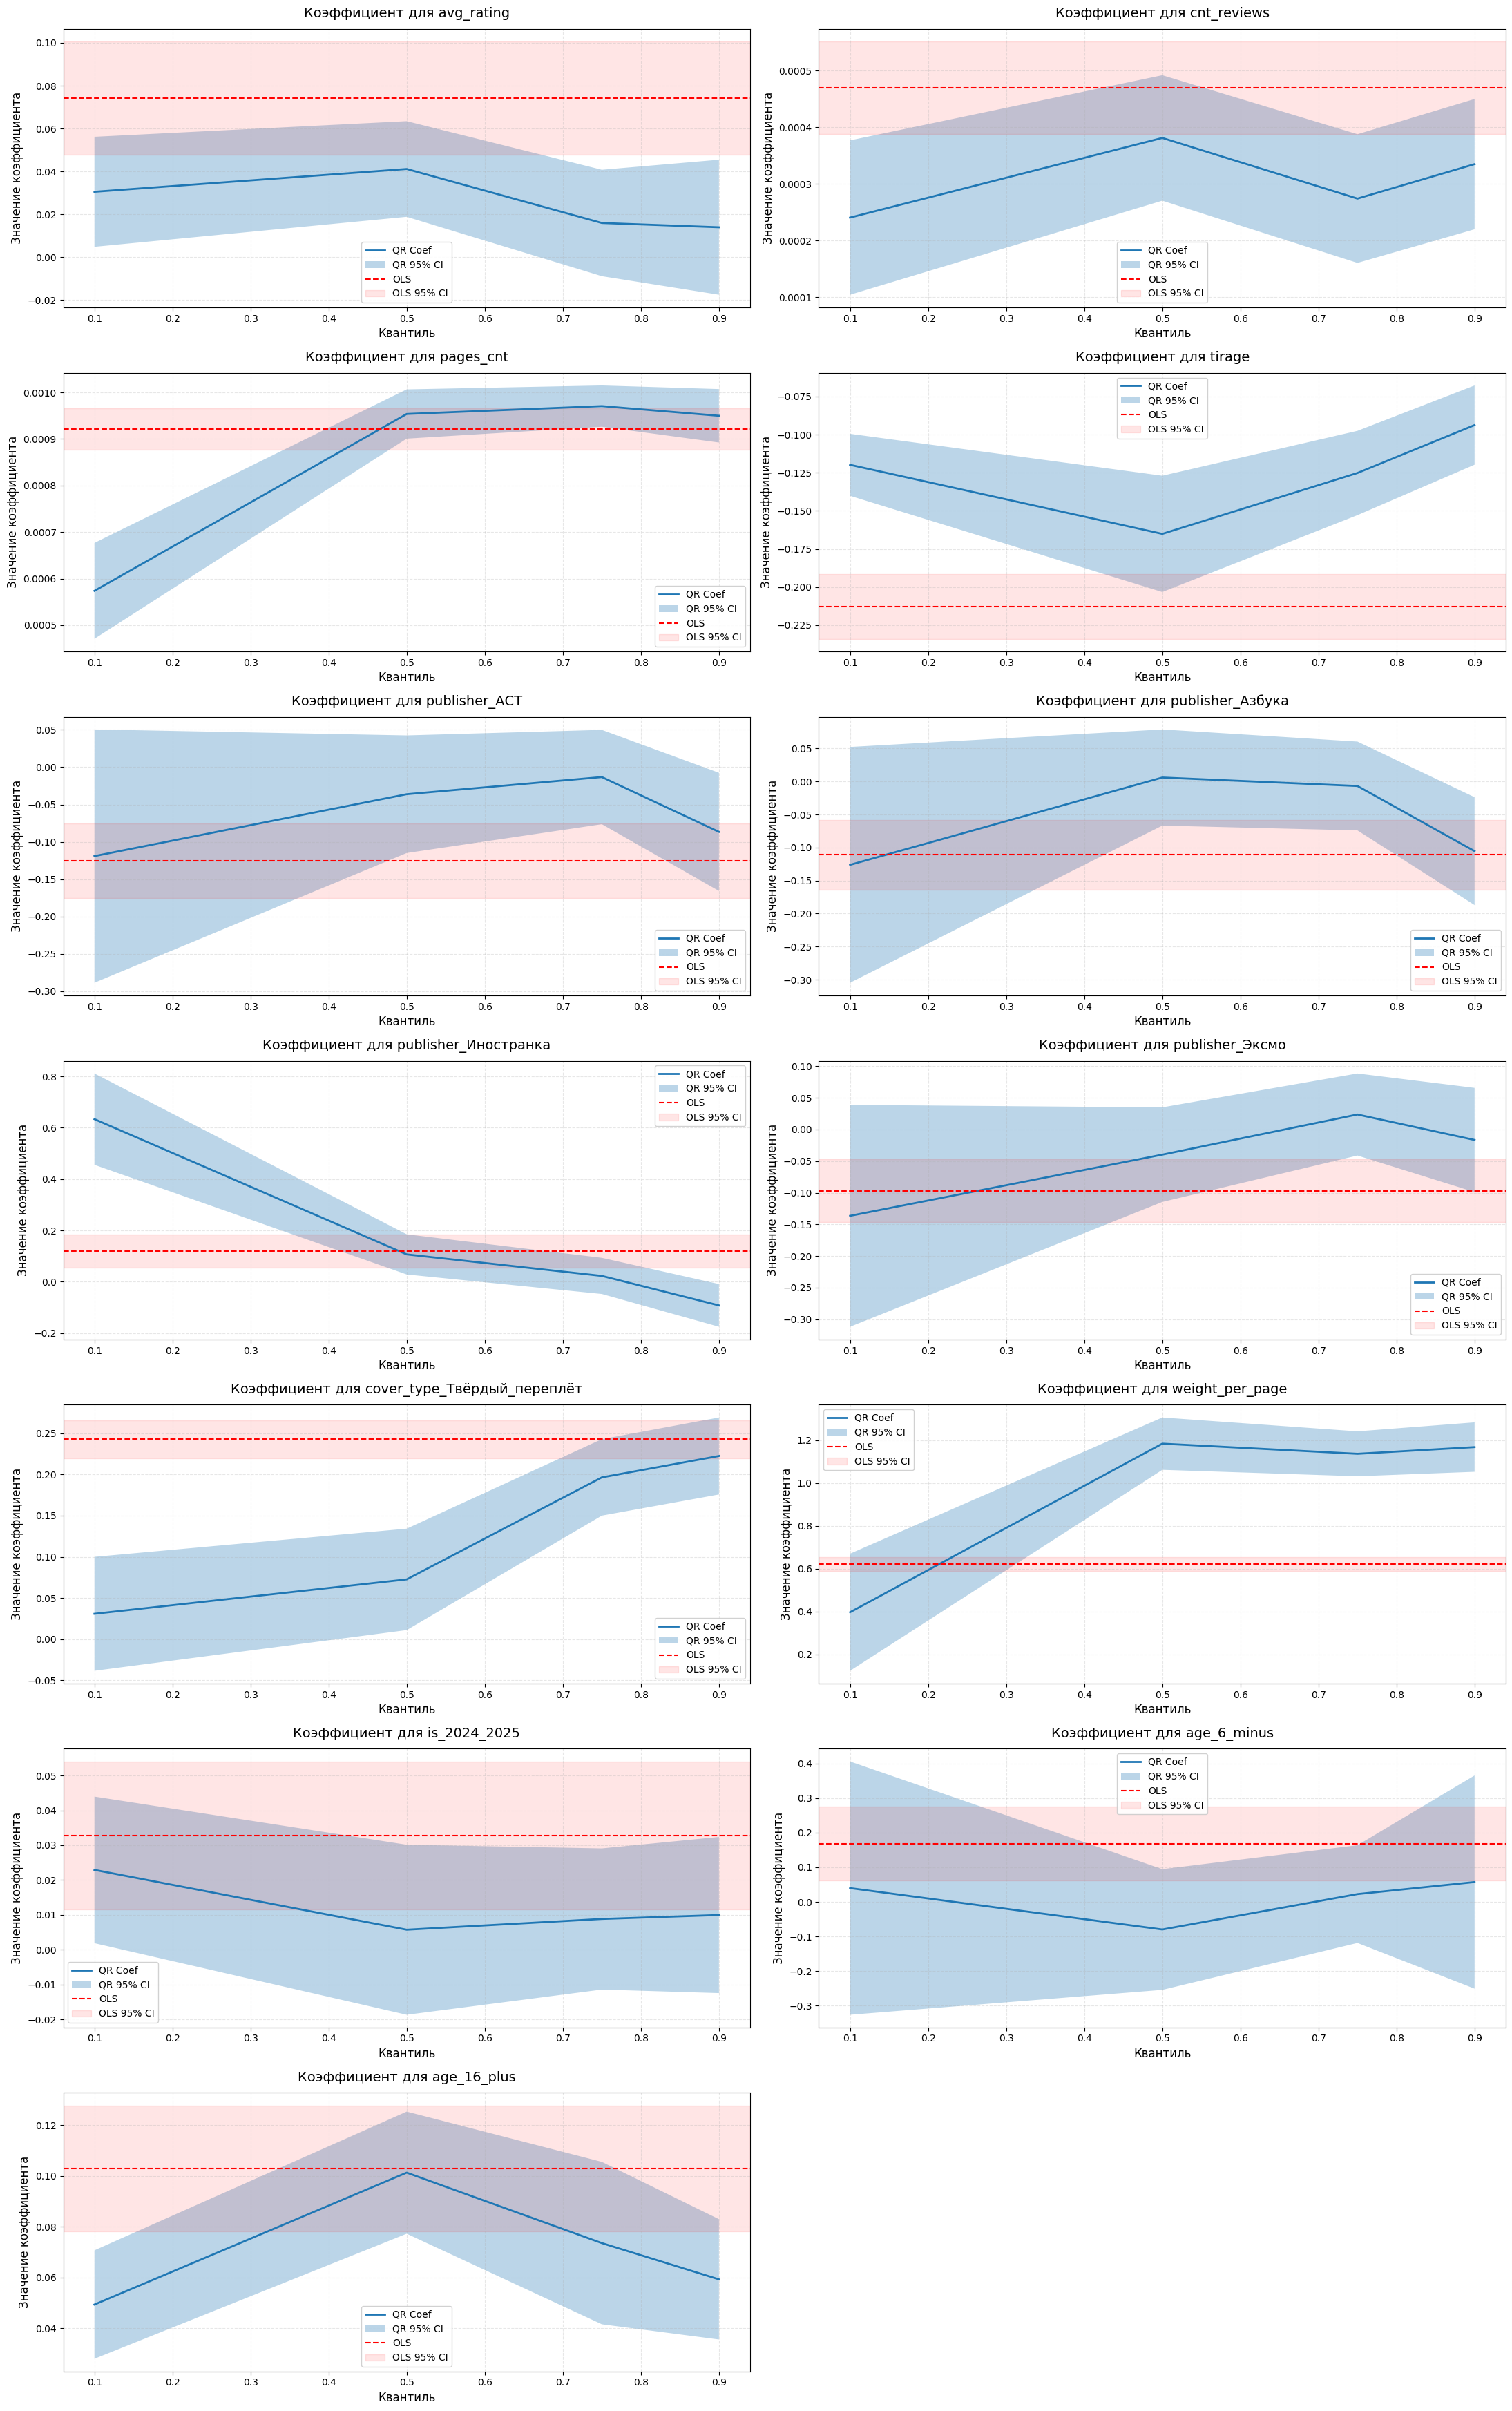

In [54]:
# Квантильная регрессия по квантилям
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем DataFrame для графиков из результатов бутстрэпа
plot_data = pd.DataFrame()
for q in quantiles_mq:
    model = models_mq[quantiles_mq.index(q)]
    coefs = pd.DataFrame({
            'quantile': q,
            # Коэффициенты
            'avg_rating': model.params['avg_rating'],
            'cnt_reviews': model.params['cnt_reviews'],
            'pages_cnt': model.params['pages_cnt'],
            'tirage': model.params['tirage'],
            'publisher_АСТ': model.params['publisher_АСТ'],
            'publisher_Азбука': model.params['publisher_Азбука'],
            'publisher_Иностранка': model.params['publisher_Иностранка'],
            'publisher_Эксмо': model.params['publisher_Эксмо'],
            'cover_type_Твёрдый_переплёт': model.params['cover_type_Твёрдый_переплёт'],
            'weight_per_page': model.params['weight_per_page'],
            'is_2024_2025': model.params['is_2024_2025'],
            'age_6_minus': model.params['age_6_minus'],
            'age_16_plus': model.params['age_16_plus'],
            'intercept': model.params['Intercept'],

            # Доверительные интервалы
            'avg_rating_lower': model.params['avg_rating'] - 1.96 * model.bse['avg_rating'],
            'avg_rating_upper': model.params['avg_rating'] + 1.96 * model.bse['avg_rating'],

            'cnt_reviews_lower': model.params['cnt_reviews'] - 1.96 * model.bse['cnt_reviews'],
            'cnt_reviews_upper': model.params['cnt_reviews'] + 1.96 * model.bse['cnt_reviews'],

            'pages_cnt_lower': model.params['pages_cnt'] - 1.96 * model.bse['pages_cnt'],
            'pages_cnt_upper': model.params['pages_cnt'] + 1.96 * model.bse['pages_cnt'],

            'tirage_lower': model.params['tirage'] - 1.96 * model.bse['tirage'],
            'tirage_upper': model.params['tirage'] + 1.96 * model.bse['tirage'],

            'publisher_АСТ_lower': model.params['publisher_АСТ'] - 1.96 * model.bse['publisher_АСТ'],
            'publisher_АСТ_upper': model.params['publisher_АСТ'] + 1.96 * model.bse['publisher_АСТ'],

            'publisher_Азбука_lower': model.params['publisher_Азбука'] - 1.96 * model.bse['publisher_Азбука'],
            'publisher_Азбука_upper': model.params['publisher_Азбука'] + 1.96 * model.bse['publisher_Азбука'],

            'publisher_Иностранка_lower': model.params['publisher_Иностранка'] - 1.96 * model.bse['publisher_Иностранка'],
            'publisher_Иностранка_upper': model.params['publisher_Иностранка'] + 1.96 * model.bse['publisher_Иностранка'],

            'publisher_Эксмо_lower': model.params['publisher_Эксмо'] - 1.96 * model.bse['publisher_Эксмо'],
            'publisher_Эксмо_upper': model.params['publisher_Эксмо'] + 1.96 * model.bse['publisher_Эксмо'],

            'cover_type_Твёрдый_переплёт_lower': model.params['cover_type_Твёрдый_переплёт'] - 1.96 * model.bse['cover_type_Твёрдый_переплёт'],
            'cover_type_Твёрдый_переплёт_upper': model.params['cover_type_Твёрдый_переплёт'] + 1.96 * model.bse['cover_type_Твёрдый_переплёт'],

            'weight_per_page_lower': model.params['weight_per_page'] - 1.96 * model.bse['weight_per_page'],
            'weight_per_page_upper': model.params['weight_per_page'] + 1.96 * model.bse['weight_per_page'],

            'is_2024_2025_lower': model.params['is_2024_2025'] - 1.96 * model.bse['is_2024_2025'],
            'is_2024_2025_upper': model.params['is_2024_2025'] + 1.96 * model.bse['is_2024_2025'],

            'age_6_minus_lower': model.params['age_6_minus'] - 1.96 * model.bse['age_6_minus'],
            'age_6_minus_upper': model.params['age_6_minus'] + 1.96 * model.bse['age_6_minus'],

            'age_16_plus_lower': model.params['age_16_plus'] - 1.96 * model.bse['age_16_plus'],
            'age_16_plus_upper': model.params['age_16_plus'] + 1.96 * model.bse['age_16_plus'],

            'intercept_lower': model.params['Intercept'] - 1.96 * model.bse['Intercept'],
            'intercept_upper': model.params['Intercept'] + 1.96 * model.bse['Intercept']
        }, index=[0])
    plot_data = pd.concat([plot_data, coefs], ignore_index=True)

# Графики для каждого предиктора
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(22, 35))
axes = axes.flatten()

for i, pred in enumerate(predictors):
    ax = axes[i]
    ols_pred_name = pred if pred != 'intercept' else 'Intercept'

    # Квантильная регрессия
    sns.lineplot(data=plot_data, x='quantile', y=pred, ax=ax,
                label='QR Coef', linewidth=2)
    ax.fill_between(plot_data['quantile'],
                   plot_data[f'{pred}_lower'],
                   plot_data[f'{pred}_upper'],
                   alpha=0.3, label='QR 95% CI')

    # OLS для сравнения
    ax.axhline(ols_model.params[ols_pred_name],
              color='red', linestyle='--',
              linewidth=1.5, label='OLS')
    ax.axhspan(ols_conf_int.loc[ols_pred_name, 0],
              ols_conf_int.loc[ols_pred_name, 1],
              color='red', alpha=0.1, label='OLS 95% CI')

    # Настройки графика
    ax.set_title(f'Коэффициент для {pred}', fontsize=14, pad=12)
    ax.set_xlabel('Квантиль', fontsize=12)
    ax.set_ylabel('Значение коэффициента', fontsize=12)
    ax.legend(fontsize=10, framealpha=0.9)
    ax.grid(True, linestyle='--', alpha=0.3)

# Удаляем лишние оси
for j in range(len(predictors), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
data.columns

Index(['price', 'avg_rating', 'cnt_reviews', 'pages_cnt', 'tirage',
       'publisher_АСТ', 'publisher_Азбука', 'publisher_Иностранка',
       'publisher_Эксмо', 'cover_type_Твёрдый_переплёт', 'weight_per_page',
       'is_2024_2025', 'age_6_minus', 'age_16_plus'],
      dtype='object')